I've noticed that all types of features contain 64 samples. So it would be good to split them into different dimensions and after it we will have input shape (64, 3) for one sample. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
train = pd.read_csv('train.csv')
print(train.shape)
print(train.describe())
print(train.isnull().sum())

(990, 194)
                id     margin1     margin2     margin3     margin4  \
count   990.000000  990.000000  990.000000  990.000000  990.000000   
mean    799.595960    0.017412    0.028539    0.031988    0.023280   
std     452.477568    0.019739    0.038855    0.025847    0.028411   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     415.250000    0.001953    0.001953    0.013672    0.005859   
50%     802.500000    0.009766    0.011719    0.025391    0.013672   
75%    1195.500000    0.025391    0.041016    0.044922    0.029297   
max    1584.000000    0.087891    0.205080    0.156250    0.169920   

          margin5     margin6     margin7     margin8     margin9  ...  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  ...   
mean     0.014264    0.038579    0.019202    0.001083    0.007167  ...   
std      0.018390    0.052030    0.017511    0.002743    0.008933  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000

In [ ]:
train=train.drop_duplicates()
def encode(train):
    label_encoder = LabelEncoder().fit(train.species)
    labels = label_encoder.transform(train.species)
    classes = list(label_encoder.classes_)

    train = train.drop(['species', 'id'], axis=1)

    return train, labels, classes

train, labels, classes = encode(train)

# standardize train features
scaler = StandardScaler().fit(train.values)
scaled_train = scaler.transform(train.values)

print("train shape",train.shape)
print("labels shape",labels.shape)
print("classes shape",len(classes))

train shape (990, 192)
labels shape (990,)
classes shape 99


In [ ]:
#plot coorelation matrix
corr = train.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style.background_gradient(cmap='coolwarm', axis=None).highlight_null(null_color='#b1'))

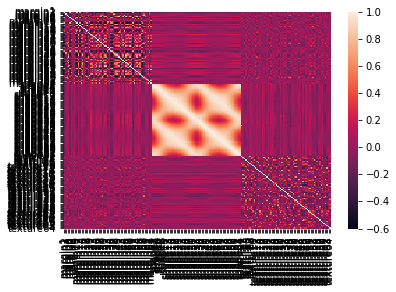

In [ ]:
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [ ]:
# split train data into train and validation
sss = StratifiedShuffleSplit(test_size=0.2, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels):
    X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_valid = labels[train_index], labels[valid_index]
    

nb_features = 64 # number of features per features type (shape, texture, margin)   
nb_class = len(classes)

# reshape train data
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features]
X_train_r[:, :, 1] = X_train[:, nb_features:128]
X_train_r[:, :, 2] = X_train[:, 128:]

# reshape validation data
X_valid_r = np.zeros((len(X_valid), nb_features, 3))
X_valid_r[:, :, 0] = X_valid[:, :nb_features]
X_valid_r[:, :, 1] = X_valid[:, nb_features:128]
X_valid_r[:, :, 2] = X_valid[:, 128:]

# Keras model with one Convolution1D layer
model = Sequential()
model.add(Convolution1D(512,2, input_shape=(nb_features, 3),activation='tanh'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(nb_class,activation='softmax'))


y_train = np_utils.to_categorical(y_train, nb_class)
y_valid = np_utils.to_categorical(y_valid, nb_class)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train_r, y_train, epochs=15, validation_data=(X_valid_r, y_valid), batch_size=5)